<a href="https://colab.research.google.com/github/ATEAM-dAIz/daiz-training-comment/blob/main/comment_BERTClassifier_DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Colab 환경 설정

####실행에 필요한 라이브러리와 KoBERT 모델을 불러온다

In [1]:
# 1. 코랩 환경 설정
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

#Kobert 파일 로드 from github
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

#토큰화
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

     |████████████████████████████████| 47.3 MB 1.1 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 5.5 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595729 sha256=e18565798949b915b25a41b663477762d0011bd2fbb34df05bd3fb2060622ed5
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 5.1 MB/s 
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 84 kB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 84.2 MB/s 
     |████████████████████████████████| 596 kB 67.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstall

####필요한 모듈을 import

In [2]:
# 환경 설정 (필요한 모듈 import)
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
import pandas as pd
from tqdm import tqdm, notebook
import random

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

####구글 드라이브 연동

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/capstone_design/

Mounted at /content/drive
/content/drive/MyDrive/capstone_design


# 2. 데이터셋 전처리

####구글 드라이브에서 데이터 파일 읽어오기

In [5]:
test_data = pd.read_excel('웰니스_대화_스크립트_데이터셋.xlsx')

####데이터 증강 함수 선언

In [6]:
import random
import pickle
import re

wordnet = {}
with open("/content/drive/MyDrive/capstone_design/wordnet.pickle", "rb") as f:
	wordnet = pickle.load(f)


# 한글만 남기고 나머지는 삭제
def get_only_hangul(line):
	parseText= re.compile('/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/').sub('',line)

	return parseText



########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################
def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			num_replaced += 1
		if num_replaced >= n:
			break

	if len(new_words) != 0:
		sentence = ' '.join(new_words)
		new_words = sentence.split(" ")

	else:
		new_words = ""

	return new_words


def get_synonyms(word):
	synomyms = []

	try:
		for syn in wordnet[word]:
			for s in syn:
				synomyms.append(s)
	except:
		pass

	return synomyms

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################
def random_deletion(words, p):
	if len(words) == 1:
		return words

	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################
def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)

	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################
def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	
	return new_words


def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		if len(new_words) >= 1:
			random_word = new_words[random.randint(0, len(new_words)-1)]
			synonyms = get_synonyms(random_word)
			counter += 1
		else:
			random_word = ""

		if counter >= 10:
			return
		
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)



def EDA(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=4):
	sentence = get_only_hangul(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not ""]
	num_words = len(words)

	augmented_sentences = []
	num_new_per_technique = int(num_aug/4) + 1

	n_sr = max(1, int(alpha_sr*num_words))
	n_ri = max(1, int(alpha_ri*num_words))
	n_rs = max(1, int(alpha_rs*num_words))

	# Synonym Replacement 특정 단어를 유의어로 교체
	for _ in range(num_new_per_technique):
		a_words = synonym_replacement(words, n_sr)
		augmented_sentences.append(' '.join(a_words))

	# Random Swap 문장 내 임의의 두 단어의 위치를 바꿈
	for _ in range(num_new_per_technique):
		a_words = random_swap(words, n_rs)
		augmented_sentences.append(" ".join(a_words))

	# Random Deletion 임의의 단어를 삭제
	for _ in range(num_new_per_technique):
		a_words = random_deletion(words, p_rd)
		augmented_sentences.append(" ".join(a_words))

	augmented_sentences = [get_only_hangul(sentence) for sentence in augmented_sentences]
	random.shuffle(augmented_sentences)

	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	augmented_sentences.append(sentence)

	return augmented_sentences

####사용자 말 데이터만 뽑기

In [7]:
wellness_dialog_human = []

nullcheck = test_data['유저'].isnull()

for emo, sen, check in zip(test_data['구분'], test_data['유저'], nullcheck):
  if check:
    continue
  else:
    augmentation_sen = EDA(sen)
    for a_sen in zip(augmentation_sen):
      data = []
      data.append(emo)
      data.append(a_sen[0])

      wellness_dialog_human.append(data)
  

wellness_dialog_human[0:5]

[['감정/감정조절이상', '제 감정이 이상해진 같아요. 것 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.'],
 ['감정/감정조절이상', '우 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.'],
 ['감정/감정조절이상', '제 감정이 이상해진 것 같아요. 남편만 보면 조절이 치밀어 오르고 감정 화가 안되요.'],
 ['감정/감정조절이상', '제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 조절이 안되요.'],
 ['감정/감정조절이상', '제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.']]

####시스템 대답 데이터만 뽑기

In [8]:
from collections import defaultdict

wellness_dialog_system = defaultdict(list)
nullcheck = test_data['챗봇'].isnull()

for emo, sen, check in zip(test_data['구분'], test_data['챗봇'], nullcheck):
  keys = wellness_dialog_system.keys()
  if check:
    continue
  else:
      wellness_dialog_system[emo].append(sen)

wellness_dialog_system

defaultdict(list,
            {'감정/감정조절이상': ['감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.',
              '저도 그 기분 이해해요. 많이 힘드시죠?',
              '그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.'],
             '감정/감정조절이상/화': ['화가 폭발할 것 같을 때는 그 자리를 피하는 것도 좋은 방법이라고 생각해요.',
              '정말 힘드시겠어요. 화는 남에게도 스스로에게도 상처를 주잖아요.',
              '화가 너무 많이 날 때는 심호흡을 해보는 게 어떨까요? 씁- 후-'],
             '감정/걱정': ['걱정이 많으시군요. 걱정거리를 정리하는 시간을 가지면 도움이 되지 않을까요?  ',
              '당연히 걱정이 되는 상황인 것 같아요. 저도 마음이 아프네요.',
              '모든 문제는 해결되기 마련이잖아요. 마음을 편히 드세요.'],
             '감정/걱정/건강문제': ['건강 때문에 걱정이 많으시군요. 잘 관리하고 계시다면 큰 문제는 없을 거예요.',
              '너무 걱정하지 마세요. 현대의학을 믿자구요.',
              '걱정이 없던 병도 만들 수 있어요. 머리를 비울 수 있게 영화를 한 편 보는 건 어때요?'],
             '감정/걱정/건강염려': ['걱정이 많이 될 거 같아요. 한번 병원에 가서 진찰을 받아보는 건 어때요?',
              '저도 그 마음 이해해요. 하지만 긍정적으로 한번 생각해보자구요.',
              '건강은 늘 걱정되는 부분인 것 같아요. '],
             '감정/걱정/경제적문제': ['돈 문제로 걱정이 많으시군요. 그럴 때는 정말 막막한 것 같아요.',
              '이럴 때 복권이라도 당첨되면 좋을 텐데요.',
    

####카테고리 데이터만 뽑기

In [9]:
wellness_dialog_category = []
cate_dict = []
category_count = 0

for emo in zip(test_data['구분']):
  if emo[0] not in cate_dict:
    cate_dict.append(emo[0])
    
    data = []
    data.append(emo[0])
    data.append(str(category_count))
    category_count += 1
    wellness_dialog_category.append(data)

wellness_dialog_category[0:5]

[['감정/감정조절이상', '0'],
 ['감정/감정조절이상/화', '1'],
 ['감정/걱정', '2'],
 ['감정/걱정/건강문제', '3'],
 ['감정/걱정/건강염려', '4']]

In [10]:
len(wellness_dialog_category)

359

####사용자 데이터에 감정 라벨링

In [11]:
# [유저, 감정숫자]

wellness_dialog_for_text_classification = []

for sen in zip(wellness_dialog_human):
  data = []
  data.append(sen[0][1])
  index = cate_dict.index(sen[0][0])
  data.append(wellness_dialog_category[index][1])
  wellness_dialog_for_text_classification.append(data)
  
print(wellness_dialog_for_text_classification[0])
print(wellness_dialog_for_text_classification[20])
print(wellness_dialog_for_text_classification[35])

['제 감정이 이상해진 같아요. 것 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.', '0']
['롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.', '0']
['더 상 혼자서는 감정조절을 못하겠어.', '0']


####전처리한 데이터(data_list)를 학습 데이터와 데스트 데이터로 나눔

In [12]:
# 3. Train data & Test data
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(wellness_dialog_for_text_classification, test_size=0.2, random_state=0)

In [13]:
print(len(dataset_train))
print(len(dataset_test))

20924
5231


####KoBERT 모델에 들어가기 위해 입력 데이터로 만들기

In [14]:
# 4. KoBERT 입력 데이터로 만들기

# BERT 모델에 들어가기 위한 dataset을 만들어주는 클래스
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

####각 인자들 세팅

In [15]:
# # Setting parameters
max_len = 200
batch_size = 16
warmup_ratio = 0.1
num_epochs = 50
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-6

####토큰화

In [16]:
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
tok = tokenizer.tokenize

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model() # BERT 모델, Vocabulary 불러오기

Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/432 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


using cached model. /content/drive/MyDrive/capstone_design/.cache/kobert_v1.zip
using cached model. /content/drive/MyDrive/capstone_design/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [17]:
data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test,0, 1, tok, vocab,  max_len, True, False) 

In [18]:
data_train

####torch 형식의 dataset 만들기

In [19]:
# torch 형식의 dataset
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)

In [20]:
train_dataloader

# 3. KoBERT 학습모델 만들기

####분류 클래스 만들기

In [21]:
# 5. KoBERT 학습모델 만들기
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 359,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

####cuda 사용

In [22]:
device = torch.device("cuda:0")

####BERT 모델 불러오고, optimizer와 스케쥴 설정, 정확도 측정 함수 작성

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [23]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
 
#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# 옵티마이저 설정
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate) # optimizer: 모델을 학습 할 때 데이터의 실제 결과와 모델이 예측한 결과를 기반으로 잘 줄일 수 있게 만들어주는 역할, 현재 가장 많이 사용하는 옵티마이저는 Adam
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs # 총 학습 과정에서 반복하게 될 스텝
warmup_step = int(t_total * warmup_ratio)

# 스케쥴러 생성
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# 4. KoBERT 모델 학습

####EarlyStopping 정의

In [24]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

####모델 학습 함수

In [25]:
def train_model(model, batch_size, patience, num_epochs):
  # 6. KoBERT 모델 학습시키기

  train_losses = [] # 모델이 학습되는 동안 trainning loss를 track
  valid_losses = [] # 모델이 학습되는 동안 validation loss를 track
  avg_train_losses = [] # epoch당 average training loss를 track
  avg_valid_losses = [] # epoch당 average validation loss를 track

  train_accuracy = []
  valid_accuracy = []

  # early_stopping object의 초기화
  early_stopping = EarlyStopping(patience = patience, verbose = True)

  # 학습 횟수만큼 학습
  for epoch in range(0, num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    # 데이터 로더에서 배치만큼 반복하여 가져옴
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()  # 그래디언트 초기화

        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        
        out = model(token_ids, valid_length, segment_ids) # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산

        loss = loss_fn(out, label) # loss 계산
        loss.backward() # backward pass: 모델의 파라미터와 관련된 loss의 그래디언트 계산
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) # 그래디언트 클리핑
        optimizer.step() # 가중치 파라미터 업데이트
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(epoch+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
        train_losses.append(loss.item()) # train loss 기록
    train_accuracy.append(train_acc / (batch_id+1))
      
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids) # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
        test_acc += calc_accuracy(out, label)
        loss = loss_fn(out, label) # loss 계산
        valid_losses.append(loss.item()) # vaildation loss 기록
    print("epoch {} test acc {}".format(epoch+1, test_acc / (batch_id+1)))
    valid_accuracy.append(test_acc / (batch_id+1))
      
    # print 학습/검증 statistics
    # epoch당 평균 loss 계산
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    epoch_len = len(str(num_epochs))
    print_msg = (f'[{epoch+1:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                      f'train_loss: {train_loss:.5f} ' +
                      f'valid_loss: {valid_loss:.5f}')
    print(print_msg)

    # 다음 에폭 track하기 위해 리스트 초기화
    train_losses = []
    valid_losses = []
      
    # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
    # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
      print("Early stopping")
      break

  # best model이 저장되어있는 last checkpoint를 로드한다.
  model.load_state_dict(torch.load('checkpoint.pt'))

  return  model, avg_train_losses, avg_valid_losses

#### CUDA out of memory 발생시 실행

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

NameError: ignored

####모델 학습

In [26]:
# early stopping patience;
# validation loss가 개선된 마지막 시간 이후로 얼마나 기다릴지 지정
patience = 20

model, train_loss, valid_loss = train_model(model, batch_size, patience, num_epochs)

  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 6.001744747161865 train acc 0.0
epoch 1 batch id 201 loss 6.055717945098877 train acc 0.003420398009950249
epoch 1 batch id 401 loss 5.922472953796387 train acc 0.0029613466334164587
epoch 1 batch id 601 loss 5.931893825531006 train acc 0.002807820299500832
epoch 1 batch id 801 loss 5.832988739013672 train acc 0.002887016229712859
epoch 1 batch id 1001 loss 5.886569976806641 train acc 0.0027472527472527475
epoch 1 batch id 1201 loss 5.852433681488037 train acc 0.0032264779350541215


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 1 test acc 0.027917940876656472
[ 1/50] train_loss: 5.92360 valid_loss: 5.82677
Validation loss decreased (inf --> 5.826771).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 5.933178901672363 train acc 0.0
epoch 2 batch id 201 loss 5.843469619750977 train acc 0.01181592039800995
epoch 2 batch id 401 loss 5.878507614135742 train acc 0.017923940149625936
epoch 2 batch id 601 loss 5.726846694946289 train acc 0.023814475873544093
epoch 2 batch id 801 loss 5.623943328857422 train acc 0.027933832709113607
epoch 2 batch id 1001 loss 5.752577304840088 train acc 0.030594405594405596
epoch 2 batch id 1201 loss 5.692004680633545 train acc 0.03424229808492923


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 2 test acc 0.05030581039755352
[ 2/50] train_loss: 5.76777 valid_loss: 5.65414
Validation loss decreased (5.826771 --> 5.654139).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 5.922577857971191 train acc 0.0
epoch 3 batch id 201 loss 5.6134138107299805 train acc 0.05472636815920398
epoch 3 batch id 401 loss 5.748159408569336 train acc 0.05517456359102244
epoch 3 batch id 601 loss 5.856644153594971 train acc 0.05875623960066556
epoch 3 batch id 801 loss 5.483874320983887 train acc 0.05914481897627965
epoch 3 batch id 1001 loss 5.515023231506348 train acc 0.05925324675324675
epoch 3 batch id 1201 loss 5.464893817901611 train acc 0.060990840965861784


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 3 test acc 0.06903669724770642
[ 3/50] train_loss: 5.58775 valid_loss: 5.42443
Validation loss decreased (5.654139 --> 5.424428).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 5.6879401206970215 train acc 0.0625
epoch 4 batch id 201 loss 5.432983875274658 train acc 0.07213930348258707
epoch 4 batch id 401 loss 5.520962715148926 train acc 0.07481296758104738
epoch 4 batch id 601 loss 5.639762878417969 train acc 0.07695507487520799
epoch 4 batch id 801 loss 5.359688758850098 train acc 0.0784956304619226
epoch 4 batch id 1001 loss 5.302330017089844 train acc 0.07973276723276723
epoch 4 batch id 1201 loss 5.092100620269775 train acc 0.08352414654454621


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 4 test acc 0.11434760448521916
[ 4/50] train_loss: 5.34501 valid_loss: 5.12971
Validation loss decreased (5.424428 --> 5.129713).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 5.601406097412109 train acc 0.125
epoch 5 batch id 201 loss 5.11489725112915 train acc 0.11069651741293532
epoch 5 batch id 401 loss 5.306391716003418 train acc 0.1137780548628429
epoch 5 batch id 601 loss 5.413402557373047 train acc 0.11720049916805325
epoch 5 batch id 801 loss 4.869028568267822 train acc 0.11961610486891386
epoch 5 batch id 1001 loss 4.943199634552002 train acc 0.123001998001998
epoch 5 batch id 1201 loss 4.6831793785095215 train acc 0.12822647793505412


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 5 test acc 0.18107798165137615
[ 5/50] train_loss: 5.02921 valid_loss: 4.76692
Validation loss decreased (5.129713 --> 4.766923).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 5.4392266273498535 train acc 0.125
epoch 6 batch id 201 loss 4.758780002593994 train acc 0.16666666666666666
epoch 6 batch id 401 loss 5.050210952758789 train acc 0.16988778054862844
epoch 6 batch id 601 loss 5.040520191192627 train acc 0.17418885191347755
epoch 6 batch id 801 loss 4.476851940155029 train acc 0.17634207240948813
epoch 6 batch id 1001 loss 4.582485675811768 train acc 0.179507992007992
epoch 6 batch id 1201 loss 4.507775783538818 train acc 0.1860428809325562


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 6 test acc 0.24587155963302754
[ 6/50] train_loss: 4.65237 valid_loss: 4.37974
Validation loss decreased (4.766923 --> 4.379743).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 5.079667568206787 train acc 0.125
epoch 7 batch id 201 loss 4.346756935119629 train acc 0.24067164179104478
epoch 7 batch id 401 loss 4.6382737159729 train acc 0.23768703241895262
epoch 7 batch id 601 loss 4.7698974609375 train acc 0.24261647254575708
epoch 7 batch id 801 loss 4.177330017089844 train acc 0.2437578027465668
epoch 7 batch id 1001 loss 4.338871479034424 train acc 0.24662837162837162
epoch 7 batch id 1201 loss 4.088662624359131 train acc 0.25228975853455454


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 7 test acc 0.30895769622833846
[ 7/50] train_loss: 4.29133 valid_loss: 4.03602
Validation loss decreased (4.379743 --> 4.036023).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 4.753642559051514 train acc 0.125
epoch 8 batch id 201 loss 4.055363655090332 train acc 0.30161691542288555
epoch 8 batch id 401 loss 4.304791450500488 train acc 0.29114713216957605
epoch 8 batch id 601 loss 4.369945526123047 train acc 0.29440515806988354
epoch 8 batch id 801 loss 3.674600601196289 train acc 0.29564606741573035
epoch 8 batch id 1001 loss 3.9034276008605957 train acc 0.2972027972027972
epoch 8 batch id 1201 loss 3.5971388816833496 train acc 0.3017277268942548


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 8 test acc 0.33762742099898063
[ 8/50] train_loss: 3.95524 valid_loss: 3.72177
Validation loss decreased (4.036023 --> 3.721773).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 4.5697021484375 train acc 0.125
epoch 9 batch id 201 loss 3.9049785137176514 train acc 0.34701492537313433
epoch 9 batch id 401 loss 4.12582540512085 train acc 0.33712593516209477
epoch 9 batch id 601 loss 3.9903464317321777 train acc 0.3383943427620632
epoch 9 batch id 801 loss 3.5200581550598145 train acc 0.3394975031210986
epoch 9 batch id 1001 loss 3.583195447921753 train acc 0.3419080919080919
epoch 9 batch id 1201 loss 3.48335599899292 train acc 0.3461698584512906


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 9 test acc 0.3812054026503568
[ 9/50] train_loss: 3.64367 valid_loss: 3.41579
Validation loss decreased (3.721773 --> 3.415790).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 4.565893650054932 train acc 0.125
epoch 10 batch id 201 loss 3.400618076324463 train acc 0.38215174129353235
epoch 10 batch id 401 loss 3.716438055038452 train acc 0.37951995012468825
epoch 10 batch id 601 loss 3.744725465774536 train acc 0.3800956738768719
epoch 10 batch id 801 loss 3.284513473510742 train acc 0.38053995006242197
epoch 10 batch id 1001 loss 3.359893321990967 train acc 0.382992007992008
epoch 10 batch id 1201 loss 3.104104995727539 train acc 0.3871253122398002


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 10 test acc 0.41275484199796125
[10/50] train_loss: 3.35913 valid_loss: 3.15154
Validation loss decreased (3.415790 --> 3.151541).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 4.191033363342285 train acc 0.1875
epoch 11 batch id 201 loss 3.0422394275665283 train acc 0.41262437810945274
epoch 11 batch id 401 loss 3.3351008892059326 train acc 0.4096009975062344
epoch 11 batch id 601 loss 3.3045332431793213 train acc 0.41243760399334445
epoch 11 batch id 801 loss 2.787198543548584 train acc 0.41245318352059923
epoch 11 batch id 1001 loss 3.0028038024902344 train acc 0.41577172827172826
epoch 11 batch id 1201 loss 2.821725368499756 train acc 0.4194941715237302


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 11 test acc 0.45251019367991846
[11/50] train_loss: 3.10223 valid_loss: 2.90633
Validation loss decreased (3.151541 --> 2.906329).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 4.07025671005249 train acc 0.125
epoch 12 batch id 201 loss 2.822824478149414 train acc 0.44402985074626866
epoch 12 batch id 401 loss 3.015852212905884 train acc 0.44809850374064836
epoch 12 batch id 601 loss 3.24958872795105 train acc 0.44717138103161397
epoch 12 batch id 801 loss 2.4541590213775635 train acc 0.44662921348314605
epoch 12 batch id 1001 loss 2.790273666381836 train acc 0.44948801198801197
epoch 12 batch id 1201 loss 2.814027786254883 train acc 0.4535803497085762


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 12 test acc 0.47124108053007135
[12/50] train_loss: 2.86150 valid_loss: 2.69031
Validation loss decreased (2.906329 --> 2.690308).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 3.871969699859619 train acc 0.25
epoch 13 batch id 201 loss 2.8085501194000244 train acc 0.4701492537313433
epoch 13 batch id 401 loss 2.681854486465454 train acc 0.4747506234413965
epoch 13 batch id 601 loss 2.8554742336273193 train acc 0.4779534109816972
epoch 13 batch id 801 loss 2.3253707885742188 train acc 0.4779962546816479
epoch 13 batch id 1001 loss 2.4321916103363037 train acc 0.4823926073926074
epoch 13 batch id 1201 loss 2.575437307357788 train acc 0.4882910074937552


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 13 test acc 0.5090978593272171
[13/50] train_loss: 2.64367 valid_loss: 2.49232
Validation loss decreased (2.690308 --> 2.492316).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 3.6343958377838135 train acc 0.1875
epoch 14 batch id 201 loss 2.6535089015960693 train acc 0.5093283582089553
epoch 14 batch id 401 loss 2.4870808124542236 train acc 0.512001246882793
epoch 14 batch id 601 loss 2.631906747817993 train acc 0.5163269550748752
epoch 14 batch id 801 loss 2.157393217086792 train acc 0.5163077403245943
epoch 14 batch id 1001 loss 2.266781806945801 train acc 0.5212912087912088
epoch 14 batch id 1201 loss 2.366962194442749 train acc 0.5243026644462948


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 14 test acc 0.5494266055045871
[14/50] train_loss: 2.44361 valid_loss: 2.30130
Validation loss decreased (2.492316 --> 2.301296).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 3.465397596359253 train acc 0.3125
epoch 15 batch id 201 loss 2.340466022491455 train acc 0.5463308457711443
epoch 15 batch id 401 loss 2.542686939239502 train acc 0.5531483790523691
epoch 15 batch id 601 loss 2.593855857849121 train acc 0.5548044925124792
epoch 15 batch id 801 loss 1.8934849500656128 train acc 0.5575842696629213
epoch 15 batch id 1001 loss 1.8180302381515503 train acc 0.5611263736263736
epoch 15 batch id 1201 loss 2.2812254428863525 train acc 0.5639571190674438


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 15 test acc 0.6004587155963302
[15/50] train_loss: 2.25511 valid_loss: 2.12422
Validation loss decreased (2.301296 --> 2.124217).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 3.150926351547241 train acc 0.375
epoch 16 batch id 201 loss 1.970758080482483 train acc 0.5799129353233831
epoch 16 batch id 401 loss 2.329862356185913 train acc 0.5885286783042394
epoch 16 batch id 601 loss 2.2292635440826416 train acc 0.5944259567387687
epoch 16 batch id 801 loss 1.8189197778701782 train acc 0.5971441947565543
epoch 16 batch id 1001 loss 1.8344554901123047 train acc 0.5984015984015985
epoch 16 batch id 1201 loss 1.9622483253479004 train acc 0.6030391340549542


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 16 test acc 0.6153797145769623
[16/50] train_loss: 2.08103 valid_loss: 1.97341
Validation loss decreased (2.124217 --> 1.973414).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 3.010171890258789 train acc 0.375
epoch 17 batch id 201 loss 1.912129521369934 train acc 0.619092039800995
epoch 17 batch id 401 loss 2.016942024230957 train acc 0.626714463840399
epoch 17 batch id 601 loss 2.0895776748657227 train acc 0.6305116472545758
epoch 17 batch id 801 loss 1.651775598526001 train acc 0.6324126092384519
epoch 17 batch id 1001 loss 1.6320774555206299 train acc 0.6358016983016983
epoch 17 batch id 1201 loss 1.9406133890151978 train acc 0.6401436303080766


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 17 test acc 0.660690621814475
[17/50] train_loss: 1.91961 valid_loss: 1.81982
Validation loss decreased (1.973414 --> 1.819824).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 2.6737494468688965 train acc 0.4375
epoch 18 batch id 201 loss 1.9701378345489502 train acc 0.6588930348258707
epoch 18 batch id 401 loss 1.8874053955078125 train acc 0.6656795511221946
epoch 18 batch id 601 loss 1.8014060258865356 train acc 0.6717970049916805
epoch 18 batch id 801 loss 1.426797866821289 train acc 0.6717384519350812
epoch 18 batch id 1001 loss 1.3889611959457397 train acc 0.6733891108891109
epoch 18 batch id 1201 loss 1.8628439903259277 train acc 0.6764154870940883


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 18 test acc 0.6882262996941897
[18/50] train_loss: 1.77221 valid_loss: 1.68162
Validation loss decreased (1.819824 --> 1.681624).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 2.7005834579467773 train acc 0.4375
epoch 19 batch id 201 loss 1.7166532278060913 train acc 0.6943407960199005
epoch 19 batch id 401 loss 1.6516234874725342 train acc 0.6984102244389028
epoch 19 batch id 601 loss 1.7194465398788452 train acc 0.7039309484193012
epoch 19 batch id 801 loss 1.290434718132019 train acc 0.7048220973782772
epoch 19 batch id 1001 loss 1.3250389099121094 train acc 0.7052947052947053
epoch 19 batch id 1201 loss 1.6389316320419312 train acc 0.7078476269775187


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 19 test acc 0.7144113149847096
[19/50] train_loss: 1.63387 valid_loss: 1.56030
Validation loss decreased (1.681624 --> 1.560298).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 2.3497602939605713 train acc 0.5
epoch 20 batch id 201 loss 1.4631271362304688 train acc 0.7157960199004975
epoch 20 batch id 401 loss 1.5282913446426392 train acc 0.72178927680798
epoch 20 batch id 601 loss 1.4499037265777588 train acc 0.7262895174708819
epoch 20 batch id 801 loss 1.2077561616897583 train acc 0.7256554307116105
epoch 20 batch id 1001 loss 1.2300838232040405 train acc 0.7286463536463537
epoch 20 batch id 1201 loss 1.567250370979309 train acc 0.7326186511240633


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 20 test acc 0.7404051987767585
[20/50] train_loss: 1.50930 valid_loss: 1.44990
Validation loss decreased (1.560298 --> 1.449896).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 2.327284097671509 train acc 0.5
epoch 21 batch id 201 loss 1.3301784992218018 train acc 0.7444029850746269
epoch 21 batch id 401 loss 1.453981637954712 train acc 0.7496882793017456
epoch 21 batch id 601 loss 1.3615933656692505 train acc 0.752599833610649
epoch 21 batch id 801 loss 1.1384426355361938 train acc 0.7510923845193508
epoch 21 batch id 1001 loss 0.9542423486709595 train acc 0.7538711288711288
epoch 21 batch id 1201 loss 1.5379117727279663 train acc 0.7568692756036636


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 21 test acc 0.7694571865443426
[21/50] train_loss: 1.39375 valid_loss: 1.33944
Validation loss decreased (1.449896 --> 1.339443).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 22 batch id 1 loss 2.0711874961853027 train acc 0.625
epoch 22 batch id 201 loss 1.2910735607147217 train acc 0.7714552238805971
epoch 22 batch id 401 loss 1.309100866317749 train acc 0.7741583541147132
epoch 22 batch id 601 loss 1.2419102191925049 train acc 0.7762063227953411
epoch 22 batch id 801 loss 1.0443147420883179 train acc 0.775749063670412
epoch 22 batch id 1001 loss 0.9735020995140076 train acc 0.7777222777222778
epoch 22 batch id 1201 loss 1.1232001781463623 train acc 0.7817964196502915


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 22 test acc 0.7843654434250765
[22/50] train_loss: 1.28895 valid_loss: 1.24529
Validation loss decreased (1.339443 --> 1.245285).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 23 batch id 1 loss 1.967583179473877 train acc 0.625
epoch 23 batch id 201 loss 1.1591277122497559 train acc 0.7916666666666666
epoch 23 batch id 401 loss 1.1357542276382446 train acc 0.7951995012468828
epoch 23 batch id 601 loss 1.1048530340194702 train acc 0.7997088186356073
epoch 23 batch id 801 loss 0.8898018598556519 train acc 0.8003277153558053
epoch 23 batch id 1001 loss 0.8554665446281433 train acc 0.8027597402597403
epoch 23 batch id 1201 loss 1.1796232461929321 train acc 0.8054746044962531


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 23 test acc 0.8113404689092762
[23/50] train_loss: 1.19409 valid_loss: 1.16153
Validation loss decreased (1.245285 --> 1.161534).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 24 batch id 1 loss 1.975648045539856 train acc 0.5625
epoch 24 batch id 201 loss 1.0778533220291138 train acc 0.8062810945273632
epoch 24 batch id 401 loss 0.9834840893745422 train acc 0.8125
epoch 24 batch id 601 loss 1.1039679050445557 train acc 0.8140599001663894
epoch 24 batch id 801 loss 0.8260862231254578 train acc 0.8142946317103621
epoch 24 batch id 1001 loss 0.9187288880348206 train acc 0.8175574425574426
epoch 24 batch id 1201 loss 1.1385681629180908 train acc 0.8206182348043297


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 24 test acc 0.826822120285423
[24/50] train_loss: 1.11367 valid_loss: 1.08721
Validation loss decreased (1.161534 --> 1.087209).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 25 batch id 1 loss 1.7856694459915161 train acc 0.625
epoch 25 batch id 201 loss 1.023660659790039 train acc 0.8286691542288557
epoch 25 batch id 401 loss 0.930983304977417 train acc 0.8307356608478803
epoch 25 batch id 601 loss 1.0388169288635254 train acc 0.8330906821963394
epoch 25 batch id 801 loss 0.8753274083137512 train acc 0.8332553058676654
epoch 25 batch id 1001 loss 0.5851889252662659 train acc 0.8351023976023976
epoch 25 batch id 1201 loss 1.1974653005599976 train acc 0.8381036636136553


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 25 test acc 0.8463175331294598
[25/50] train_loss: 1.03364 valid_loss: 1.01776
Validation loss decreased (1.087209 --> 1.017756).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 26 batch id 1 loss 1.6484487056732178 train acc 0.75
epoch 26 batch id 201 loss 1.0116239786148071 train acc 0.8435945273631841
epoch 26 batch id 401 loss 0.7967732548713684 train acc 0.8456982543640897
epoch 26 batch id 601 loss 0.8892385363578796 train acc 0.8471297836938436
epoch 26 batch id 801 loss 0.779915452003479 train acc 0.8476903870162297
epoch 26 batch id 1001 loss 0.6659711599349976 train acc 0.8507742257742258
epoch 26 batch id 1201 loss 1.0347009897232056 train acc 0.8532472939217319


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 26 test acc 0.8560652395514781
[26/50] train_loss: 0.96740 valid_loss: 0.95666
Validation loss decreased (1.017756 --> 0.956662).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 27 batch id 1 loss 1.5893551111221313 train acc 0.6875
epoch 27 batch id 201 loss 0.7835012674331665 train acc 0.8603855721393034
epoch 27 batch id 401 loss 0.8879944086074829 train acc 0.8608167082294265
epoch 27 batch id 601 loss 0.854917049407959 train acc 0.862936772046589
epoch 27 batch id 801 loss 0.6324056386947632 train acc 0.8653245942571786
epoch 27 batch id 1001 loss 0.5733398795127869 train acc 0.8670704295704296
epoch 27 batch id 1201 loss 0.891075611114502 train acc 0.869691923397169


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 27 test acc 0.8677242609582059
[27/50] train_loss: 0.90221 valid_loss: 0.90062
Validation loss decreased (0.956662 --> 0.900616).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 28 batch id 1 loss 1.6003721952438354 train acc 0.625
epoch 28 batch id 201 loss 0.7377009391784668 train acc 0.8706467661691543
epoch 28 batch id 401 loss 0.7784028053283691 train acc 0.8725062344139651
epoch 28 batch id 601 loss 0.7360447645187378 train acc 0.8768718801996672
epoch 28 batch id 801 loss 0.6448497772216797 train acc 0.8791354556803995
epoch 28 batch id 1001 loss 0.47042620182037354 train acc 0.8808066933066933
epoch 28 batch id 1201 loss 0.9247477650642395 train acc 0.8820774354704413


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 28 test acc 0.8768985728848114
[28/50] train_loss: 0.84771 valid_loss: 0.84878
Validation loss decreased (0.900616 --> 0.848778).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 29 batch id 1 loss 1.4330201148986816 train acc 0.8125
epoch 29 batch id 201 loss 0.7077193856239319 train acc 0.8958333333333334
epoch 29 batch id 401 loss 0.6633026599884033 train acc 0.8941708229426434
epoch 29 batch id 601 loss 0.7580057382583618 train acc 0.8933028286189684
epoch 29 batch id 801 loss 0.6919334530830383 train acc 0.8941167290886392
epoch 29 batch id 1001 loss 0.5726368427276611 train acc 0.8957917082917083
epoch 29 batch id 1201 loss 0.8165076971054077 train acc 0.8977414654454621


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 29 test acc 0.8841615698267075
[29/50] train_loss: 0.79568 valid_loss: 0.80399
Validation loss decreased (0.848778 --> 0.803990).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 30 batch id 1 loss 1.344212293624878 train acc 0.75
epoch 30 batch id 201 loss 0.7250019311904907 train acc 0.894589552238806
epoch 30 batch id 401 loss 0.6234055161476135 train acc 0.8982231920199502
epoch 30 batch id 601 loss 0.7256227731704712 train acc 0.8999584026622296
epoch 30 batch id 801 loss 0.5790435075759888 train acc 0.9012952559300874
epoch 30 batch id 1001 loss 0.4855685830116272 train acc 0.9020979020979021
epoch 30 batch id 1201 loss 0.8686649203300476 train acc 0.9048709408825978


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 30 test acc 0.8942915392456677
[30/50] train_loss: 0.75018 valid_loss: 0.76584
Validation loss decreased (0.803990 --> 0.765836).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 31 batch id 1 loss 1.288063883781433 train acc 0.875
epoch 31 batch id 201 loss 0.6104272603988647 train acc 0.9095149253731343
epoch 31 batch id 401 loss 0.5880899429321289 train acc 0.90928927680798
epoch 31 batch id 601 loss 0.6849738359451294 train acc 0.9125415973377704
epoch 31 batch id 801 loss 0.5926095843315125 train acc 0.9131554307116105
epoch 31 batch id 1001 loss 0.5368571281433105 train acc 0.9143356643356644
epoch 31 batch id 1201 loss 0.7492726445198059 train acc 0.9157472939217319


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 31 test acc 0.9055682976554537
[31/50] train_loss: 0.70913 valid_loss: 0.72807
Validation loss decreased (0.765836 --> 0.728066).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 32 batch id 1 loss 1.2019169330596924 train acc 0.875
epoch 32 batch id 201 loss 0.6402825713157654 train acc 0.9213308457711443
epoch 32 batch id 401 loss 0.5510408878326416 train acc 0.916926433915212
epoch 32 batch id 601 loss 0.6238425970077515 train acc 0.9200291181364393
epoch 32 batch id 801 loss 0.5707080960273743 train acc 0.9216604244694132
epoch 32 batch id 1001 loss 0.4600735306739807 train acc 0.9231393606393606
epoch 32 batch id 1201 loss 0.6737901568412781 train acc 0.9241777685262281


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 32 test acc 0.9105377166156983
[32/50] train_loss: 0.67629 valid_loss: 0.69713
Validation loss decreased (0.728066 --> 0.697134).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 33 batch id 1 loss 1.3426785469055176 train acc 0.6875
epoch 33 batch id 201 loss 0.5268300771713257 train acc 0.9247512437810945
epoch 33 batch id 401 loss 0.4960807263851166 train acc 0.9259663341645885
epoch 33 batch id 601 loss 0.6274001598358154 train acc 0.9284525790349417
epoch 33 batch id 801 loss 0.46354085206985474 train acc 0.929229088639201
epoch 33 batch id 1001 loss 0.3848723769187927 train acc 0.9293831168831169
epoch 33 batch id 1201 loss 0.7930530309677124 train acc 0.9311511240632806


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 33 test acc 0.9197120285423038
[33/50] train_loss: 0.64457 valid_loss: 0.66901
Validation loss decreased (0.697134 --> 0.669010).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 34 batch id 1 loss 1.1615962982177734 train acc 0.8125
epoch 34 batch id 201 loss 0.6448398232460022 train acc 0.9294154228855721
epoch 34 batch id 401 loss 0.46236100792884827 train acc 0.9300187032418953
epoch 34 batch id 601 loss 0.5321072936058044 train acc 0.9313643926788685
epoch 34 batch id 801 loss 0.4953506886959076 train acc 0.9318820224719101
epoch 34 batch id 1001 loss 0.36249107122421265 train acc 0.9326298701298701
epoch 34 batch id 1201 loss 0.7247771620750427 train acc 0.9337531223980017


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 34 test acc 0.9273572884811417
[34/50] train_loss: 0.61735 valid_loss: 0.64518
Validation loss decreased (0.669010 --> 0.645177).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 35 batch id 1 loss 1.171981692314148 train acc 0.9375
epoch 35 batch id 201 loss 0.5052624344825745 train acc 0.9368781094527363
epoch 35 batch id 401 loss 0.4499453604221344 train acc 0.9370324189526185
epoch 35 batch id 601 loss 0.5345430374145508 train acc 0.9380199667221298
epoch 35 batch id 801 loss 0.4879201650619507 train acc 0.9391385767790262
epoch 35 batch id 1001 loss 0.3326444625854492 train acc 0.9409340659340659
epoch 35 batch id 1201 loss 0.6936097145080566 train acc 0.9417152373022482


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 35 test acc 0.9281218144750255
[35/50] train_loss: 0.59337 valid_loss: 0.62401
Validation loss decreased (0.645177 --> 0.624011).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 36 batch id 1 loss 1.1440244913101196 train acc 0.9375
epoch 36 batch id 201 loss 0.49785444140434265 train acc 0.9493159203980099
epoch 36 batch id 401 loss 0.3979128897190094 train acc 0.9454488778054863
epoch 36 batch id 601 loss 0.4847128391265869 train acc 0.9458194675540765
epoch 36 batch id 801 loss 0.48227205872535706 train acc 0.9463951310861424
epoch 36 batch id 1001 loss 0.3487018346786499 train acc 0.9463036963036963
epoch 36 batch id 1201 loss 0.6284971833229065 train acc 0.9470753538717736


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 36 test acc 0.9319444444444445
[36/50] train_loss: 0.57138 valid_loss: 0.60454
Validation loss decreased (0.624011 --> 0.604538).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 37 batch id 1 loss 0.9839215874671936 train acc 0.9375
epoch 37 batch id 201 loss 0.3730193078517914 train acc 0.9493159203980099
epoch 37 batch id 401 loss 0.4676409661769867 train acc 0.9452930174563591
epoch 37 batch id 601 loss 0.47526559233665466 train acc 0.9478993344425957
epoch 37 batch id 801 loss 0.36940380930900574 train acc 0.9486579275905118
epoch 37 batch id 1001 loss 0.28117138147354126 train acc 0.9491133866133866
epoch 37 batch id 1201 loss 0.6292476058006287 train acc 0.9492089925062448


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 37 test acc 0.9336646279306829
[37/50] train_loss: 0.55260 valid_loss: 0.58884
Validation loss decreased (0.604538 --> 0.588837).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 38 batch id 1 loss 0.9811626076698303 train acc 1.0
epoch 38 batch id 201 loss 0.4410741627216339 train acc 0.9508706467661692
epoch 38 batch id 401 loss 0.42477214336395264 train acc 0.9513715710723192
epoch 38 batch id 601 loss 0.48608696460723877 train acc 0.9524750415973378
epoch 38 batch id 801 loss 0.4192526638507843 train acc 0.952169163545568
epoch 38 batch id 1001 loss 0.30345380306243896 train acc 0.952485014985015
epoch 38 batch id 1201 loss 0.6410641670227051 train acc 0.9535803497085762


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 38 test acc 0.9367227319062181
[38/50] train_loss: 0.53654 valid_loss: 0.57507
Validation loss decreased (0.588837 --> 0.575071).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 39 batch id 1 loss 1.0833381414413452 train acc 0.875
epoch 39 batch id 201 loss 0.4590373933315277 train acc 0.9539800995024875
epoch 39 batch id 401 loss 0.39528658986091614 train acc 0.9533977556109726
epoch 39 batch id 601 loss 0.392863929271698 train acc 0.9553868552412645
epoch 39 batch id 801 loss 0.43662577867507935 train acc 0.9559925093632958
epoch 39 batch id 1001 loss 0.3264942169189453 train acc 0.955919080919081
epoch 39 batch id 1201 loss 0.5483387112617493 train acc 0.9568068276436303


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 39 test acc 0.9395897043832824
[39/50] train_loss: 0.52583 valid_loss: 0.56466
Validation loss decreased (0.575071 --> 0.564661).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 40 batch id 1 loss 0.9325668811798096 train acc 1.0
epoch 40 batch id 201 loss 0.4368635416030884 train acc 0.9589552238805971
epoch 40 batch id 401 loss 0.3811589479446411 train acc 0.9569825436408977
epoch 40 batch id 601 loss 0.4279631972312927 train acc 0.9582986688851913
epoch 40 batch id 801 loss 0.34498289227485657 train acc 0.9585674157303371
epoch 40 batch id 1001 loss 0.3204348087310791 train acc 0.9591658341658341
epoch 40 batch id 1201 loss 0.5941104292869568 train acc 0.9600853455453788


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 40 test acc 0.9436034658511723
[40/50] train_loss: 0.51345 valid_loss: 0.55472
Validation loss decreased (0.564661 --> 0.554719).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 41 batch id 1 loss 1.0170551538467407 train acc 0.875
epoch 41 batch id 201 loss 0.3583127558231354 train acc 0.9577114427860697
epoch 41 batch id 401 loss 0.4295087158679962 train acc 0.9560473815461347
epoch 41 batch id 601 loss 0.48885706067085266 train acc 0.9578826955074875
epoch 41 batch id 801 loss 0.3845629096031189 train acc 0.9584113607990012
epoch 41 batch id 1001 loss 0.27891868352890015 train acc 0.9586038961038961
epoch 41 batch id 1201 loss 0.6777842044830322 train acc 0.9602414654454621


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 41 test acc 0.944559123343527
[41/50] train_loss: 0.50171 valid_loss: 0.54656
Validation loss decreased (0.554719 --> 0.546555).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 42 batch id 1 loss 1.048985242843628 train acc 0.875
epoch 42 batch id 201 loss 0.4554097652435303 train acc 0.9598880597014925
epoch 42 batch id 401 loss 0.39827510714530945 train acc 0.9588528678304239
epoch 42 batch id 601 loss 0.4583543837070465 train acc 0.9585066555740432
epoch 42 batch id 801 loss 0.42230841517448425 train acc 0.9580212234706617
epoch 42 batch id 1001 loss 0.21311351656913757 train acc 0.9596028971028971
epoch 42 batch id 1201 loss 0.5882056951522827 train acc 0.9608659450457951


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 42 test acc 0.9472349643221203
[42/50] train_loss: 0.49508 valid_loss: 0.54009
Validation loss decreased (0.546555 --> 0.540087).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 43 batch id 1 loss 0.9041616320610046 train acc 0.9375
epoch 43 batch id 201 loss 0.4243320822715759 train acc 0.9639303482587065
epoch 43 batch id 401 loss 0.439564049243927 train acc 0.9633728179551122
epoch 43 batch id 601 loss 0.36264723539352417 train acc 0.9628743760399334
epoch 43 batch id 801 loss 0.3585037291049957 train acc 0.9624687890137328
epoch 43 batch id 1001 loss 0.32740318775177 train acc 0.9630369630369631
epoch 43 batch id 1201 loss 0.5864796042442322 train acc 0.9632077435470441


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 43 test acc 0.9466615698267075
[43/50] train_loss: 0.49148 valid_loss: 0.53439
Validation loss decreased (0.540087 --> 0.534392).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 44 batch id 1 loss 0.8934349417686462 train acc 0.9375
epoch 44 batch id 201 loss 0.43605101108551025 train acc 0.9614427860696517
epoch 44 batch id 401 loss 0.3410172462463379 train acc 0.9590087281795511
epoch 44 batch id 601 loss 0.4239712059497833 train acc 0.959130615640599
epoch 44 batch id 801 loss 0.39422672986984253 train acc 0.9604400749063671
epoch 44 batch id 1001 loss 0.3331211805343628 train acc 0.9601648351648352
epoch 44 batch id 1201 loss 0.5442368984222412 train acc 0.9616465445462115


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 44 test acc 0.9495285423037717
[44/50] train_loss: 0.48550 valid_loss: 0.53057
Validation loss decreased (0.534392 --> 0.530569).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 45 batch id 1 loss 0.8854650855064392 train acc 1.0
epoch 45 batch id 201 loss 0.3973274230957031 train acc 0.9676616915422885
epoch 45 batch id 401 loss 0.3715600371360779 train acc 0.9655548628428927
epoch 45 batch id 601 loss 0.4154960811138153 train acc 0.9659941763727121
epoch 45 batch id 801 loss 0.39085978269577026 train acc 0.9654338327091136
epoch 45 batch id 1001 loss 0.23237252235412598 train acc 0.9652847152847153
epoch 45 batch id 1201 loss 0.5502904057502747 train acc 0.9657056619483764


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 45 test acc 0.9499108053007136
[45/50] train_loss: 0.48098 valid_loss: 0.52736
Validation loss decreased (0.530569 --> 0.527363).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 46 batch id 1 loss 0.9935014843940735 train acc 0.9375
epoch 46 batch id 201 loss 0.4515324532985687 train acc 0.9633084577114428
epoch 46 batch id 401 loss 0.3227201998233795 train acc 0.9636845386533666
epoch 46 batch id 601 loss 0.39027830958366394 train acc 0.9626663893510815
epoch 46 batch id 801 loss 0.33877772092819214 train acc 0.9624687890137328
epoch 46 batch id 1001 loss 0.2959524095058441 train acc 0.9634115884115884
epoch 46 batch id 1201 loss 0.5185592770576477 train acc 0.9634159034138218


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 46 test acc 0.9491462793068298
[46/50] train_loss: 0.48167 valid_loss: 0.52566
Validation loss decreased (0.527363 --> 0.525663).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 47 batch id 1 loss 0.7870258092880249 train acc 1.0
epoch 47 batch id 201 loss 0.3922366797924042 train acc 0.9673507462686567
epoch 47 batch id 401 loss 0.3527233302593231 train acc 0.9650872817955112
epoch 47 batch id 601 loss 0.4092463254928589 train acc 0.9648502495840267
epoch 47 batch id 801 loss 0.32144710421562195 train acc 0.9652777777777778
epoch 47 batch id 1001 loss 0.2600397765636444 train acc 0.965472027972028
epoch 47 batch id 1201 loss 0.49479228258132935 train acc 0.9658617818484596


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 47 test acc 0.9502930682976555
[47/50] train_loss: 0.47834 valid_loss: 0.52424
Validation loss decreased (0.525663 --> 0.524243).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 48 batch id 1 loss 0.8294127583503723 train acc 0.9375
epoch 48 batch id 201 loss 0.39396417140960693 train acc 0.9661069651741293
epoch 48 batch id 401 loss 0.4012365937232971 train acc 0.963216957605985
epoch 48 batch id 601 loss 0.34092554450035095 train acc 0.9641222961730449
epoch 48 batch id 801 loss 0.40082141757011414 train acc 0.9644194756554307
epoch 48 batch id 1001 loss 0.3012274503707886 train acc 0.9648476523476524
epoch 48 batch id 1201 loss 0.5384466052055359 train acc 0.9653934221482098


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 48 test acc 0.9504841997961264
[48/50] train_loss: 0.47688 valid_loss: 0.52373
Validation loss decreased (0.524243 --> 0.523729).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 49 batch id 1 loss 0.9181208610534668 train acc 0.875
epoch 49 batch id 201 loss 0.47989901900291443 train acc 0.9657960199004975
epoch 49 batch id 401 loss 0.37530168890953064 train acc 0.9647755610972568
epoch 49 batch id 601 loss 0.3620230555534363 train acc 0.9645382695507487
epoch 49 batch id 801 loss 0.312977135181427 train acc 0.9644194756554307
epoch 49 batch id 1001 loss 0.25336048007011414 train acc 0.9647227772227772
epoch 49 batch id 1201 loss 0.5391749143600464 train acc 0.9657056619483764


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 49 test acc 0.9508664627930683
[49/50] train_loss: 0.47711 valid_loss: 0.52345
Validation loss decreased (0.523729 --> 0.523453).  Saving model ...




  0%|          | 0/1308 [00:00<?, ?it/s]

epoch 50 batch id 1 loss 0.94153892993927 train acc 0.875
epoch 50 batch id 201 loss 0.34235233068466187 train acc 0.9645522388059702
epoch 50 batch id 401 loss 0.34133267402648926 train acc 0.9636845386533666
epoch 50 batch id 601 loss 0.3553004264831543 train acc 0.9646422628951747
epoch 50 batch id 801 loss 0.4084259569644928 train acc 0.9648096129837703
epoch 50 batch id 1001 loss 0.2899484634399414 train acc 0.9653471528471529
epoch 50 batch id 1201 loss 0.5224663615226746 train acc 0.9666944213155704


  0%|          | 0/327 [00:00<?, ?it/s]

epoch 50 test acc 0.9506753312945974
[50/50] train_loss: 0.47683 valid_loss: 0.52343
Validation loss decreased (0.523453 --> 0.523434).  Saving model ...




####[참고]loss랑 early stopping 체크포인트 가시화

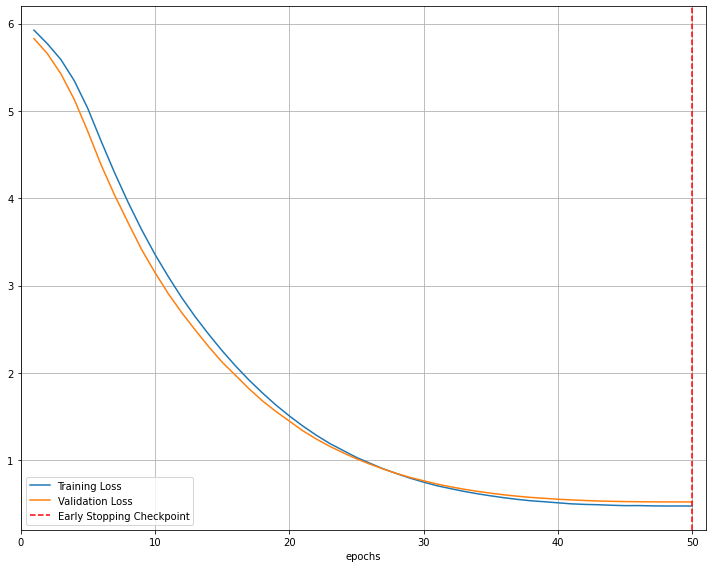

In [27]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

In [ ]:
# 저장하기
state = {
        'epoch': num_epochs,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': valid_loss,
}
path ="/content/drive/MyDrive/capstone_design/comment.pt"
torch.save(state, path)

NameError: ignored

# 5. 테스트

#### 테스트 함수 작성

In [28]:
# 7. 새로운 문장 테스트
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids) # forward pass: compute predicted outputs by passing inputs to the model

        test_eval=[]
        for i in out:
            logits = i
            
            softmax_logit = torch.softmax(logits, dim=-1)
            softmax_logit = softmax_logit.squeeze()

            max_index = torch.argmax(softmax_logit).item()
            max_index_value = softmax_logit[torch.argmax(softmax_logit)].item()

            print('"', predict_sentence, '"')
            print('카테고리 : ', wellness_dialog_category[max_index][0])
            index = wellness_dialog_category[max_index][0]

            comment_list = wellness_dialog_system[index]
            print('코멘트 후보 : ', comment_list)

            comment_len = len(comment_list) - 1
            comment_index = random.randint(0, comment_len)
            print('코멘트 : ', comment_list[comment_index])

####테스트 실행

In [30]:
predict('이번 일은 없던걸로 넘어가야겠어. 너무 짜증나.')
print('-'*80)
predict('제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요')
print('-'*80)
predict('감정이 이상해진 것 같다. 남편놈만 보면 화가 나고 감정 조절이 안된다. 이놈의 집구석. 내가 나가든 쟤가 나가든 해야지 정말..')
print('-'*80)
predict('얼른 끝내고 친구들이랑 놀러가고싶다')
print('-'*80)
predict('얼른 과제를 끝내고 친구들이랑 놀러가고싶다')
print('-'*80)
predict('얼른 과제 끝내고 친구들이랑 놀러가야지!!!')
print('-'*80)
predict('나 1등 됐어!')
print('-'*80)
predict('나 드디어 1등 했어!')
print('-'*80)
predict('드디어 1등을 했다! 노력한 보람이 있다. 너무 좋아서 눈물날거같다. 앞으로도 열심히 해야지.')
print('-'*80)
predict('나 학사경고 받았어')
print('-'*80)
predict('1학년땐 놀아도 된다고 그래서 놀았는데 학사경고 받았다. 작작 놀걸... 엄마한텐 뭐라말하지ㅋㅋ쿠ㅜㅜㅜㅜ')
print('-'*80)
predict('엄마아빠가 오늘도 싸웠다. 그만 싸우면 좋겠다. 이런 상황이 너무 싫어서 집 나가버리고 싶다.')
print('-'*80)
predict('나는 여유로운 사람이 되고싶은데 그러기 참 쉽지않은 것 같다. 오늘도 언니한테 나도 모르게 짜증을 냈다. 왜 이렇게 난 속좁은 사람이 되가는걸까?')
print('-'*80)
predict('나만 티켓팅 실패했다. 인생 아무 의미 없다. 나만 락페 못가..')
print('-'*80)
predict('요즘 하루하루가 바쁘지만 인생에 활력이 넘치는 것 같아서 그렇게 힘들지는 않다. 열심히 살자!')
print('-'*80)
predict('오늘 회사에서 멍청한 실수를 했다. 여러번 확인했는데 생각하지도 못한데서 오류가 있었다. 내 자신이 너무 부끄러웠다. 다음부턴 더 꼼꼼하게 살펴야겠다.')
print('-'*80)
predict('엄마한테 라일락꽃이랑 안개꽃을 선물했다. 엄마가 정말 좋아하셔서 나도 기분이 좋았다. 엄마 사랑해. 나랑 오래오래 살자.')
print('-'*80)
predict('우리집 고양이가 많이 아프다. 동물병원에 갔는데 급성신부전이 왔다고 한다. 예후도 좋지않아서 마음의 준비를 하라고 했다. 나는 우리 나비를 보낼 준비가 아직 안됐다. 불쌍한 우리 나비. 내가 정신을 똑바로 차려야된다. 이제 병원도 다시 알아보고, 좋은 보조제도 찾아봐야지...')
print('-'*80)
predict('드디어 종강했다. 이번 여름에는 친구들이랑 여수에 가기로 했다. 존맛탱 간장게장도 먹고 삼합에 소주도 마셔야지~! 너무 기대된다!!')
print('-'*80)
predict('드디어 취업했다!! 결과 페이지 보고 너무 좋아서 소리질렀다. 아빠가 취업기념 소고기를 사주셨다. 오늘 정말 행복한 하루였다.')
print('-'*80)
predict('나만 취업을 못하고 있다.. 너무 우울하고 나자신이 너무 초라해진다. 나 취직할 수 있을까? 나도 잘 모르겠다..')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


" 이번 일은 없던걸로 넘어가야겠어. 너무 짜증나. "
카테고리 :  감정/짜증
코멘트 후보 :  ['그런 일이 있었군요. 기분이 많이 나빴겠어요.', '으휴, 제가 대신 혼내주고 싶네요!', '달달한 걸 먹으면 짜증이 달아날 거예요.', '짜증이 날 때 일부러 크게 웃는 것도 좋은 방법인 것 같아요.']
코멘트 :  으휴, 제가 대신 혼내주고 싶네요!
--------------------------------------------------------------------------------
" 제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요 "
카테고리 :  감정/감정조절이상
코멘트 후보 :  ['감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.', '저도 그 기분 이해해요. 많이 힘드시죠?', '그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.']
코멘트 :  감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.
--------------------------------------------------------------------------------
" 감정이 이상해진 것 같다. 남편놈만 보면 화가 나고 감정 조절이 안된다. 이놈의 집구석. 내가 나가든 쟤가 나가든 해야지 정말.. "
카테고리 :  감정/감정조절이상
코멘트 후보 :  ['감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.', '저도 그 기분 이해해요. 많이 힘드시죠?', '그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.']
코멘트 :  그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.
--------------------------------------------------------------------------------
" 얼른 끝내고 친구들이랑 놀러가고싶다 "
카테고리 :  배경/부모
코멘트 후보 :  ['그런 일이 있으셨군요. ', '네, 더 말씀해주세요